In [62]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
result = pd.read_csv("data/generation_analysis/final_model_results.csv", index_col=0)

In [30]:
# sequences are all decoded with || slamba * opt_125m's prob + llambda * opt_30b's prob ||
# check out the decoding algorithm in utils.py: decode_sequence_with_lambda
# generated sequences' perplexity from the final model checkpoints and intermediate checkpoints of all model sizes
result.head()

,task,topp,slambda,llambda,max_length,mauve,opt_125m,opt_1.3b,opt_6.7b,opt_13b,opt_30b,opt_125m_ckpts,opt_1.3b_ckpts,opt_6.7b_ckpts,opt_13b_ckpts,opt_30b_ckpts,data_file,out_file
0,stories,0.9,1.0,-1.0,500,0.067827,22.633865,50.217513,57.744117,58.622162,64.568745,"{2000: 60.40115541903938, 6000: 43.33961398761...","{2000: 44.05897197092692, 6000: 39.22052656297...","{2000: 42.323159835287704, 6000: 46.1709556691...","{2000: 44.148116333502266, 6000: 49.4929825553...","{2000: 42.574221568710534, 10000: 57.121245529...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
1,stories,0.9,1.0,-1.0,100,0.229974,33.734318,73.954677,86.049415,88.021278,98.506746,"{2000: 80.83753372377325, 6000: 60.80397196506...","{2000: 61.17846121643792, 6000: 55.64034479662...","{2000: 59.43265353648847, 6000: 64.57252289773...","{2000: 62.722070314389036, 6000: 71.8699617923...","{2000: 60.72923166652278, 10000: 82.8592141763...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
2,stories,0.9,1.0,-1.0,50,0.433136,41.543851,88.314237,104.057260,106.429258,120.688171,"{2000: 93.72113626368183, 6000: 73.32504749833...","{2000: 73.55179321585737, 6000: 66.83021103574...","{2000: 73.77052273552962, 6000: 78.28137156426...","{2000: 80.02486685128862, 6000: 87.04152744205...","{2000: 75.00739490770826, 10000: 99.8574980875...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
3,stories,0.9,1.0,-0.8,500,0.087904,15.921004,30.600301,34.671475,35.050906,37.768270,"{2000: 37.63842132937073, 6000: 27.51886081178...","{2000: 27.27084793199129, 6000: 24.08284016496...","{2000: 25.94764658622549, 6000: 27.90269786132...","{2000: 27.59567994530331, 6000: 29.98764244339...","{2000: 25.91782815751337, 10000: 33.7265563425...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
4,stories,0.9,1.0,-0.8,100,0.272185,24.767812,47.334663,54.790935,55.955125,61.504152,"{2000: 54.71283956431799, 6000: 41.94614185572...","{2000: 41.14848745862837, 6000: 37.12823457966...","{2000: 39.808909343230134, 6000: 42.0153745777...","{2000: 41.75694724792697, 6000: 46.64761543680...","{2000: 40.47907678231056, 10000: 52.6316048881...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...


In [20]:
def get_row_index(df, cond):
    return list(df[cond].index)

In [43]:
# select the result of a certain validation set, max_length, and decoding strategy

task = "stories"
max_length = 50 # 50, 100
topp = 0.0 # 0.0: greedy, 0.9: top-p

subdf = result[(result["task"] == task) & (result["max_length"] == max_length) & (result["topp"] == topp)]

In [39]:
subdf.head()

,task,topp,slambda,llambda,max_length,mauve,opt_125m,opt_1.3b,opt_6.7b,opt_13b,opt_30b,opt_125m_ckpts,opt_1.3b_ckpts,opt_6.7b_ckpts,opt_13b_ckpts,opt_30b_ckpts,data_file,out_file
64,stories,0.0,1.0,-1.0,100,0.176425,7.663095,13.859023,15.652993,15.897339,17.349268,"{2000: 15.708402743993439, 6000: 12.4153697102...","{2000: 11.884960363760296, 6000: 10.7942544151...","{2000: 11.482077845380154, 6000: 12.1943450618...","{2000: 12.17443218359553, 6000: 13.46996692277...","{2000: 11.819917241413254, 10000: 15.163437503...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
67,stories,0.0,1.0,-0.8,100,0.114685,4.597279,6.776991,7.430184,7.549886,7.947160,"{2000: 7.9102200076480225, 6000: 6.54811490411...","{2000: 6.2755485835751275, 6000: 5.71557685104...","{2000: 6.129794126279251, 6000: 6.270162531644...","{2000: 6.313971212277974, 6000: 6.743289110994...","{2000: 6.225123522834429, 10000: 7.26490479256...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
70,stories,0.0,1.0,-0.6,100,0.052800,3.469406,4.546745,4.867599,4.956040,5.119881,"{2000: 5.43497125481641, 6000: 4.6549106803149...","{2000: 4.449286219046139, 6000: 4.144100917382...","{2000: 4.407321202023256, 6000: 4.419475833025...","{2000: 4.464062129350884, 6000: 4.597224508928...","{2000: 4.41730292121286, 10000: 4.853973686389...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
73,stories,0.0,1.0,-0.4,100,0.017691,2.706997,3.173752,3.312049,3.349469,3.432969,"{2000: 3.82798943075383, 6000: 3.4266469827921...","{2000: 3.307922335395427, 6000: 3.079516738392...","{2000: 3.289962928461811, 6000: 3.250078160988...","{2000: 3.2824111456094833, 6000: 3.27228375163...","{2000: 3.278802049724108, 10000: 3.39728915645...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...
76,stories,0.0,1.0,-0.2,100,0.013724,2.450764,2.715176,2.805308,2.826979,2.867246,"{2000: 3.3059749537364347, 6000: 3.00745236064...","{2000: 2.9064845172367617, 6000: 2.72717789225...","{2000: 2.912463507028479, 6000: 2.834116831831...","{2000: 2.873676199785917, 6000: 2.825133063037...","{2000: 2.851401840579419, 10000: 2.88929320969...",/checkpoint/mengzhouxia/out/opt_125m/contrastm...,/checkpoint/mengzhouxia/out/opt_125m/contrastm...


### print generations of different slambda and llamba

In [44]:
from utils import pull_out_generation

for seed in [2]:
    for index in get_row_index(subdf, (subdf["slambda"] == 1.0) & (subdf["llambda"] == -1.0)) + \
                 get_row_index(subdf, (subdf["slambda"] == 1.0) & (subdf["llambda"] == 0.0)) + \
                 get_row_index(subdf, (subdf["slambda"] == 1.0) & (subdf["llambda"] == 1.0)) + \
                 get_row_index(subdf, (subdf["slambda"] == 0.0) & (subdf["llambda"] == 1.0)) + \
                 get_row_index(subdf, (subdf["slambda"] == -1.0) & (subdf["llambda"] == 1.0)):
        for feature in ["topp", "slambda", "llambda", "max_length", "mauve"]:
            print(f"{feature}:",round(float(subdf.loc[index, feature]), 4), end="\t")
        slambda = int(subdf.loc[index, "slambda"])
        llambda = int(subdf.loc[index, "llambda"])
        data_file = f"data/generation_analysis/generation/smodel_opt_125m_lmodel_opt_30b-topp{topp}-maxl{max_length}-sl{slambda}-ll{llambda}.jsonl"
        pull_out_generation(data_file, 1, seed)

topp: 0.0	slambda: 1.0	llambda: -1.0	max_length: 50.0	mauve: 0.2773	Selected index: [309]
******************************
As Jennifer drove home on her bicycle from work in New Jersey to New Jersey, she stopped to take in a view of a large tree that is now covered in a large, tall tree.
"I'm just so happy," she said.
Jennifer was driving to work in a field when the tree started growing, she said, then stopped to take in a view of a tree that is now covered in a large tree. (Photo: Getty)
The tree was covered with a tree trunk, she added, and the trunk was cut down to make room to grow a new branch. Jennifer's car was then driven to work in the field, where she picked up a tree that had grown in the field, Jennifer said.
The tree was cut down at the same time that Jennifer was picking up another tree that was still growing, Jennifer added.
Jennifer and her husband, Jason Todd Todd, drove to work in the fields in the early morning hours on Saturday morning. (Photo by Sarah W. Brown/Getty 

### plot perplexity trajectory of generated sequences

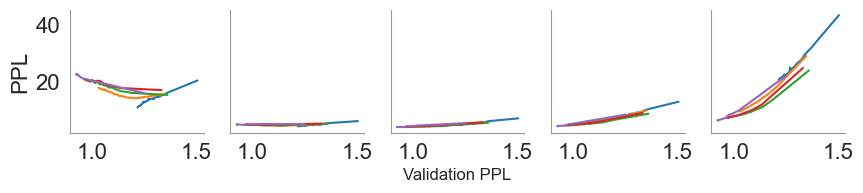

In [60]:
from utils import return_color, load_opt_validation_ppl, get_xaxis, return_opt_model_sizes
validation_ppl = load_opt_validation_ppl()

suum = subdf["slambda"].astype(float) + subdf["llambda"].astype(float)
selected_subdf = subdf[(suum == 1) | (suum == 0) | (suum == 2)]

sns.set_style("white")
num = len(selected_subdf)
models = [c for c in selected_subdf.columns if "opt" in c and "ckpts" not in c]

xaxis_type = "ppl" # ppl, Tokens, Steps

fontsize = 16
height = 0.8
fig, axes = plt.subplots(1, num, figsize=(num * 2, height * 2), sharey=True, sharex=True)
for i, index in enumerate(selected_subdf.index):
    for j, model in enumerate(models):
        ckpt_scores = eval(selected_subdf.loc[index, f"{model}_ckpts"])
        steps = sorted(int(x) for x in ckpt_scores.keys())
        ys = [ckpt_scores[x] for x in steps]
        xs = get_xaxis(model, steps, xaxis_type, xaxis_log=True) 
        axes[i].plot(xs, ys, label=model, color=return_color(model))
    if i == 0:
        sns.despine(top=True, right=True, left=False, bottom=False, ax=axes[i])
        axes[i].set_ylabel("PPL", fontsize=fontsize)
    else:
        plt.setp(axes[i].get_yticklabels(), visible=False)

if xaxis_type == "ppl":
    axes[2].set_xlabel("Validation PPL", fontsize=12)
else:
    axes[2].set_xlabel(xaxis_type, fontsize=12)
    if xaxis_type == "FLOPs":
        FLOPs = range(18, 24, 3)
        for ax in axes:
            ax.set_xticks(list(FLOPs), [f"$10^{{{x}}}$" for x in FLOPs], fontsize=12)

for ax in axes:
    sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)
    ax.spines['left'].set_color('#989898')
    ax.spines['bottom'].set_color('#989898')
    ax.tick_params(axis='both', which='major', labelsize=fontsize) 
   

out_file = f"images/section2/{task}_{topp}_{max_length}_{xaxis_type}.pdf"
if not os.path.exists(os.path.dirname(out_file)):
    plt.savefig(out_file, dpi=300, bbox_inches='tight')

### plot perplexity of the generations with gpt-neo models

In [61]:
def convert_to_df(all_losses):
    d = {"slambda": [], "llambda": [], "EleutherAI/gpt-neo-125M": [], "EleutherAI/gpt-neo-1.3B": [], "EleutherAI/gpt-neo-2.7B": [], "data_file": []}
    for i, model in enumerate(all_losses):
        for item in all_losses[model]:
            data_file = item["data_file"]
            subdir = [s for s in data_file.split("/") if "lmodel" in s][0]
            sl_index = subdir.index("sl")
            ll_index = subdir.index("-ll")
            slambda = float(subdir[sl_index+2:ll_index])
            llambda = float(subdir[ll_index+3:])
            
            if i == 0:
                d["slambda"].append(slambda); d["llambda"].append(llambda)
                d["data_file"].append(data_file)
            d[model].append(item["perplexity"])
    df = pd.DataFrame(d)
    return df

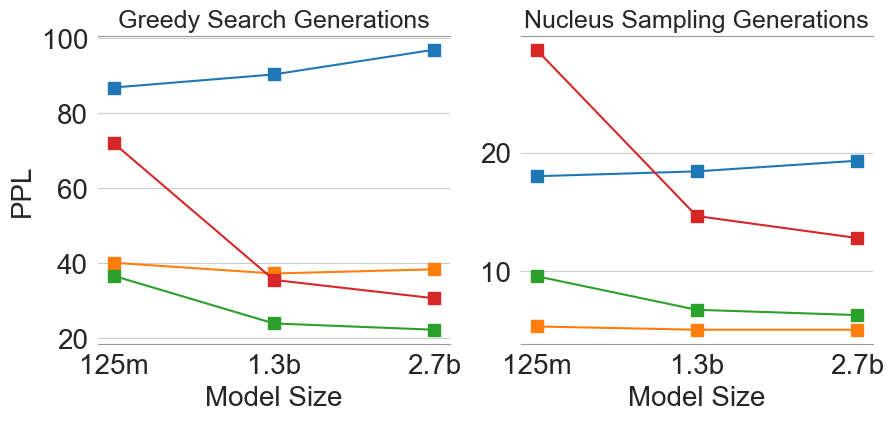

In [66]:

topp=0.9
file = f"data/generation_analysis/neogpt-evaluation/{task}-maxl{max_length}-topp{topp}.pt"
gptneo_re_ns = convert_to_df(torch.load(file))

topp=0.0
file = f"data/generation_analysis/neogpt-evaluation/{task}-maxl{max_length}-topp{topp}.pt"
gptnep_re_gs = convert_to_df(torch.load(file))

colors = [plt.cm.tab20(i) for i in range(20)]
fontsize=20
sns.set_style("white")
num = len(gptneo_re_ns)
models = [c for c in gptneo_re_ns.columns if "gpt" in c]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = ["$p_s - p_t$", "$p_s$", "$p_t$", "$p_t - p_s$"]

for j in range(2):
    ax = axes[j]
    if j == 0: # nucleus sampling
        ddf = gptneo_re_ns
    else:
        ddf = gptnep_re_gs
    for i, index in enumerate(ddf.index):
        y = [ddf.loc[index, model] for model in models]
        ax.plot(["125m", "1.3b", "2.7b"], y, color=colors[2*i], marker="s", markersize=8, label=labels[i])
        if np.isnan(y).any():
            continue
    
    if j == 0:
        ax.set_ylabel("PPL", fontsize=fontsize)
    ax.set_xlabel("Model Size", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_title(f"{'Greedy Search Generations' if j == 0 else 'Nucleus Sampling Generations'}", fontsize=18)
    sns.set_style("whitegrid")
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    sns.despine(left=True, bottom=False, top=False)
    ax.spines['top'].set_color('#989898')
    ax.spines['bottom'].set_color('#989898')

out_file = f"images/section2/{task}_{topp}_{max_length}_gptneo.pdf"
if not os.path.exists(os.path.dirname(out_file)):
    plt.savefig(out_file, dpi=300, bbox_inches='tight')